In [ ]:
# Dowload the dataset from kaggle
import os
os.environ['KAGGLE_USERNAME'] = 'xxxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxx'
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.87G/1.88G [00:35<00:00, 73.6MB/s]
100% 1.88G/1.88G [00:35<00:00, 56.4MB/s]
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: job_skills.csv          
  inflating: job_summary.csv         
  inflating: linkedin_job_postings.csv  


In [ ]:
# Install pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=6488f69d93dbd59bb7239917f287d8e4c6cb98f48c0bc0b1949afca3b5c1089b
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


**MARKET BASKET ANALYSIS**

In [ ]:
# Load the libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, trim, isnull, lower, regexp_replace, collect_set, sum as _sum
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import warnings
warnings.filterwarnings("ignore") # Just to ignore any possible warnings
from pyspark.ml.fpm import FPGrowth # To implement the FP-Growth algorithm

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Market Basket Analysis") \
    .getOrCreate()
spark

In [ ]:
# Load the dataset
df = spark.read.csv('job_skills.csv', header=True, inferSchema=True)

In [ ]:
# Show the schema and first few rows of the DataFrame
df.printSchema()
df.show(5, truncate=False)

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                        

In [ ]:
# Show the total number of rows
df.describe().show()
print(f"Number of rows in df: {df.count()}")

+-------+--------------------+-------------------------------+
|summary|            job_link|                     job_skills|
+-------+--------------------+-------------------------------+
|  count|             1296381|                        1294374|
|   mean|                NULL|                           NULL|
| stddev|                NULL|                           NULL|
|    min|https://ae.linked...|           "* Maintenance, *...|
|    max|https://za.linked...|志愿服务, 沟通, 陪伴, 临终服...|
+-------+--------------------+-------------------------------+

Number of rows in df: 1296381


In [ ]:
# Count the number of NaN values in the 'job_skills' column
nan_count = df.filter(isnull(col("job_skills"))).count()
print(f"Number of NaN values in 'job_skills' column: {nan_count}")

Number of NaN values in 'job_skills' column: 2007


In [ ]:
# Drop rows with null values in the 'job_skills' column
df = df.dropna(subset=["job_skills"])

In [ ]:
# Select the first row of the 'job_skills' column and count the number of total skills
first_row = df.select(df.columns[1]).first()[0]
print(first_row)
print(f"Number of skills in the first row: {len(first_row.split(','))}")

Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety Protocols, Communication Skills, Attention to Detail, Physical Strength, Experience in Housekeeping
Number of skills in the first row: 14


In [ ]:
# Select the second row of the 'job_skills' column and count the number of total skills
second_row = df.select(df.columns[1]).take(2)[1][0]
print(second_row)
print(f"Number of skills in the second row: {len(second_row.split(','))}")

Customer service, Restaurant management, Food safety, Training, Supervision, Scheduling, Inventory, Cost control, Sales, Communication, Problemsolving, Leadership, Motivation, Teamwork, High School Diploma, Bachelor's Degree, ServSafe Certification, Valid Driver's License, Physical ability to perform job duties
Number of skills in the second row: 19


In [ ]:
# Split the skills by comma and create an array
df = df.withColumn("skills_array", split(col("job_skills"), ","))
df.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Explode the array to get a row for each skill
exploded_df = df.withColumn("skill", explode(col("skills_array")))
exploded_df.show(5, truncate=False)
print(f"Number of rows in exploded_df: {exploded_df.count()}")

+-----------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
|job_link                                                                                       |job_skills                                                                                                                                                                                                              

In [ ]:
# Remove special characters, unnecessary spaces and convert everything to lowercase
cleaned_skills = exploded_df.withColumn("skill", trim(lower(regexp_replace(col("skill"), r'[^\w\s]', ''))))
cleaned_skills.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+
|job_link                                                                                       |job_skills                                                                                                                                                                                                              

In [ ]:
# Counts the number of unique skills
unique_skills_count = cleaned_skills.select("skill").distinct().count()
print(f"Total number of unique skills: {unique_skills_count}")

Total number of unique skills: 2723885


In [ ]:
# Group the skills together and count how many times each of them appears
grouped_skills = cleaned_skills.groupBy("skill").count()
grouped_skills.show(10, truncate=False)

+---------------------------------------+-----+
|skill                                  |count|
+---------------------------------------+-----+
|standards                              |3804 |
|youth intake                           |1    |
|travel                                 |35037|
|understanding policies and procedures  |6    |
|vehicle maintenance                    |2416 |
|it skills                              |2455 |
|urine test                             |5    |
|sustainable design                     |554  |
|radiation health and safety certificate|15   |
|art                                    |630  |
+---------------------------------------+-----+
only showing top 10 rows



In [ ]:
# Sort skills by most and least frequent
most_common_skills = grouped_skills.orderBy(col("count").desc())
least_common_skills = grouped_skills.orderBy(col("count").asc())

In [ ]:
# Show the 15 most common skills
most_common_skills.show(15, truncate=False)

+--------------------+------+
|skill               |count |
+--------------------+------+
|communication       |370482|
|customer service    |278418|
|teamwork            |227812|
|communication skills|196131|
|leadership          |185346|
|problem solving     |149177|
|time management     |143047|
|attention to detail |134092|
|problemsolving      |129464|
|project management  |121688|
|interpersonal skills|100335|
|patient care        |99979 |
|sales               |93141 |
|nursing             |88072 |
|collaboration       |87169 |
+--------------------+------+
only showing top 15 rows



In [ ]:
# Show the 15 least common skills
least_common_skills.show(15, truncate=False)

+-----------------------------------------------------------------------+-----+
|skill                                                                  |count|
+-----------------------------------------------------------------------+-----+
|care competencies                                                      |1    |
|project pursuit process and methodology understanding                  |1    |
|hosthostess or food service experience                                 |1    |
|configuration management tooling                                       |1    |
|sequencing optimization                                                |1    |
|controlling food waste and loss                                        |1    |
|ability to work independently and productively with minimal supervision|1    |
|enterprise storage devices                                             |1    |
|ability to handle multiple situations simultaneously                   |1    |
|national and international clientele   

In [ ]:
# Replace the variant "problemsolving" with "problem solving"
grouped_skills = grouped_skills.withColumn("skill", regexp_replace(col("skill"), r"problemsolving", "problem solving"))

# Replace the variant "communication skills" with just "communication"
grouped_skills = grouped_skills.withColumn("skill", regexp_replace(col("skill"), r"communication skills", "communication"))

# Group again by 'skill' and add the counts to unify the duplicate skills
grouped_skills = grouped_skills.groupBy("skill").agg(_sum("count").alias("count"))

In [ ]:
# Sort again the skills by most frequent
most_common_skills = grouped_skills.orderBy(col("count").desc())
most_common_skills.show(15, truncate=False)

+--------------------+------+
|skill               |count |
+--------------------+------+
|communication       |566613|
|problem solving     |278641|
|customer service    |278418|
|teamwork            |227812|
|leadership          |185346|
|time management     |143047|
|attention to detail |134092|
|project management  |121688|
|interpersonal skills|100335|
|patient care        |99979 |
|sales               |93141 |
|nursing             |88072 |
|collaboration       |87169 |
|training            |83736 |
|data analysis       |82038 |
+--------------------+------+
only showing top 15 rows



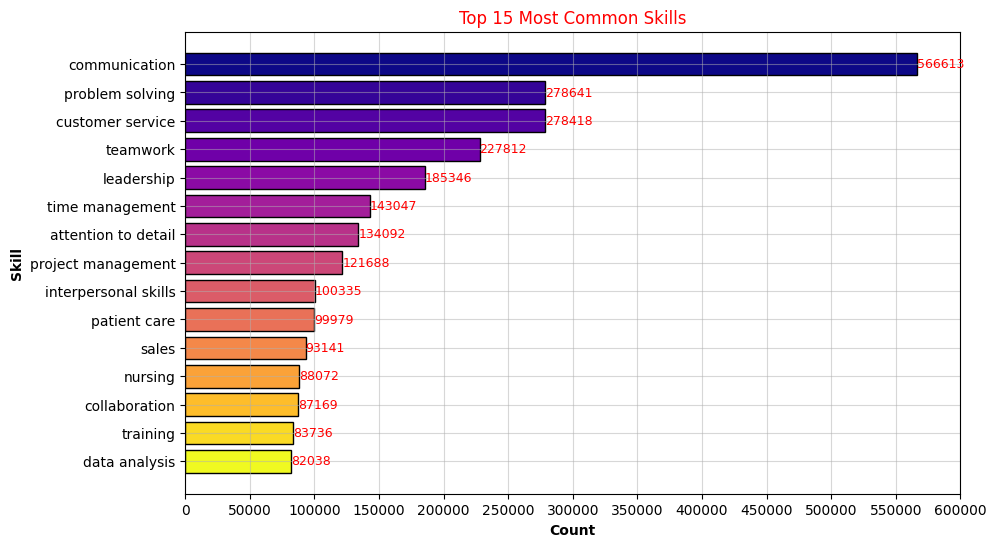

In [ ]:
# Convert PySpark DataFrames to Pandas DataFrames for visualize the plot
most_common_skills_pd = most_common_skills.limit(15).toPandas()

# Plot the top 15 most common skills
plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(most_common_skills_pd))) # List of colors for bars
bars = plt.barh(most_common_skills_pd['skill'], most_common_skills_pd['count'], color=colors, edgecolor='black') # Create the bars for each skill
plt.title('Top 15 Most Common Skills', color='red') # Set the title
plt.xlabel('Count', fontweight='bold') # Set axis name
plt.ylabel('Skill', fontweight='bold')
plt.grid(True, linestyle='-', alpha=0.5) # Add a grid
plt.xticks(np.arange(0, most_common_skills_pd['count'].max() + 50000, 50000)) # Set axis numbers

# Show the exact count for each bar (each skill)
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width()}',
             va='center',
             ha='left',
             fontsize=9,
             color='red')

plt.gca().invert_yaxis() # Show the skills in desc order
plt.show()

In [ ]:
# Merge the grouped DataFrame (after the replacement) with the original (cleaned) dataset
grouped_cleaned_skills = cleaned_skills.join(grouped_skills, on="skill", how="inner")

In [ ]:
# Create baskets by grouping by 'job_link' and collecting the unique skills for each job
baskets = grouped_cleaned_skills.groupBy("job_link").agg(collect_set("skill").alias("skills"))
baskets.show(10, truncate=False) # View first 10 baskets (jobs) with related skills

+----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                                                    |skills                                                                                                                                                                                                                      

In [ ]:
# Show the schema of the new Dataframe
baskets.printSchema()
print(f"Number of rows in baskets: {baskets.count()}") # Count the total number of baskets

root
 |-- job_link: string (nullable = true)
 |-- skills: array (nullable = false)
 |    |-- element: string (containsNull = false)

Number of rows in baskets: 1294365


**APRIORI ALGORITHM**

In [ ]:
# Convert the 'skills' column to a set RDD
baskets_rdd = baskets.select("skills").rdd.map(lambda row: set(row.skills)).cache()

Compute the most frequent singletons

In [ ]:
# Define support threshold
support = 5000

In [ ]:
# Find frequent singletons considering the size of the support
first_pass = baskets_rdd.flatMap(lambda basket: [(e, 1) for e in basket]) \
                        .reduceByKey(lambda x, y: x + y) \
                        .filter(lambda x: x[1] > support)

# Output of frequent singletons
print(f"Total number of frequent singletons: {first_pass.count()}")
print("Sample of 15 frequent singletons:")
for singleton in first_pass.take(15):
    print(singleton)

Total number of frequent singletons: 534
Sample of 15 frequent singletons:
('care coordination', 6365)
('machine learning', 9613)
('business development', 25106)
('sales management', 8553)
('competitive compensation', 5133)
('leadership', 183839)
('financial management', 13358)
('written and verbal communication', 5202)
('consulting', 5196)
('interpersonal communication', 9699)
('health insurance', 28684)
('patient care', 99451)
('employee discounts', 5565)
('clinical skills', 6180)
('customer satisfaction', 6074)


Compute the most frequent pairs


In [ ]:
# Collect frequent singletons
frequent_singletons = set(first_pass.map(lambda x: x[0]).collect())

# Find frequent item pairs with the same support size
second_pass = baskets_rdd.flatMap(lambda basket: [(pair, 1) for pair in combinations(sorted(basket), 2)]) \
                        .filter(lambda x: x[0][0] in frequent_singletons and x[0][1] in frequent_singletons) \
                        .reduceByKey(lambda x, y: x + y) \
                        .filter(lambda x: x[1] > support)

# Output of frequent pairs
print(f"Total number of frequent item pairs: {second_pass.count()}")
print("Sample of 15 frequent item pairs:")
for pair in second_pass.take(15):
    print(pair)

Total number of frequent item pairs: 1091
Sample of 15 frequent item pairs:
(('time management', 'verbal communication'), 8097)
(('account management', 'sales'), 8880)
(('analytical skills', 'communication'), 19398)
(('analytical skills', 'problem solving'), 15115)
(('attention to detail', 'training'), 9871)
(('financial management', 'leadership'), 5473)
(('attention to detail', 'decision making'), 7216)
(('customer service', 'initiative'), 7987)
(('initiative', 'time management'), 7454)
(('organizational skills', 'time management skills'), 5905)
(('attention to detail', 'merchandising'), 6285)
(('mentoring', 'project management'), 6418)
(('customer service', 'positive attitude'), 6398)
(('collaboration', 'customer service'), 13362)
(('project management', 'verbal communication'), 6053)


Compute the most frequent triplets

In [ ]:
# Collect frequent pairs
frequent_pairs = set(second_pass.map(lambda x: x[0]).collect())

# Find frequent item triplets (again with the same support)
third_pass = baskets_rdd.flatMap(lambda basket: [(triplet, 1) for triplet in combinations(sorted(basket), 3)]) \
                        .filter(lambda x: (x[0][0], x[0][1]) in frequent_pairs and
                                         (x[0][1], x[0][2]) in frequent_pairs and
                                         (x[0][0], x[0][2]) in frequent_pairs) \
                        .reduceByKey(lambda x, y: x + y) \
                        .filter(lambda x: x[1] > support)

# Output of frequent triplets
print(f"Total number of frequent item triplets: {third_pass.count()}")
print("Sample of 15 frequent item triplets:")
for triplet in third_pass.take(15):
    print(triplet)

Total number of frequent item triplets: 795
Sample of 15 frequent item triplets:
(('adaptability', 'problem solving', 'teamwork'), 11051)
(('excel', 'powerpoint', 'word'), 7356)
(('attention to detail', 'communication', 'training'), 7270)
(('leadership', 'problem solving', 'training'), 9700)
(('interpersonal skills', 'leadership', 'teamwork'), 6244)
(('leadership', 'microsoft office suite', 'teamwork'), 6655)
(('adaptability', 'communication', 'decision making'), 5031)
(('adaptability', 'communication', 'leadership'), 14758)
(('attention to detail', 'communication', 'teamwork'), 38629)
(('communication', 'organizational skills', 'time management'), 11887)
(('conflict resolution', 'leadership', 'problem solving'), 8279)
(('coaching', 'customer service', 'leadership'), 10589)
(('attention to detail', 'customer service', 'teamwork'), 27886)
(('attention to detail', 'flexibility', 'teamwork'), 11364)
(('collaboration', 'communication', 'project management'), 9717)


Plot the most frequent pairs

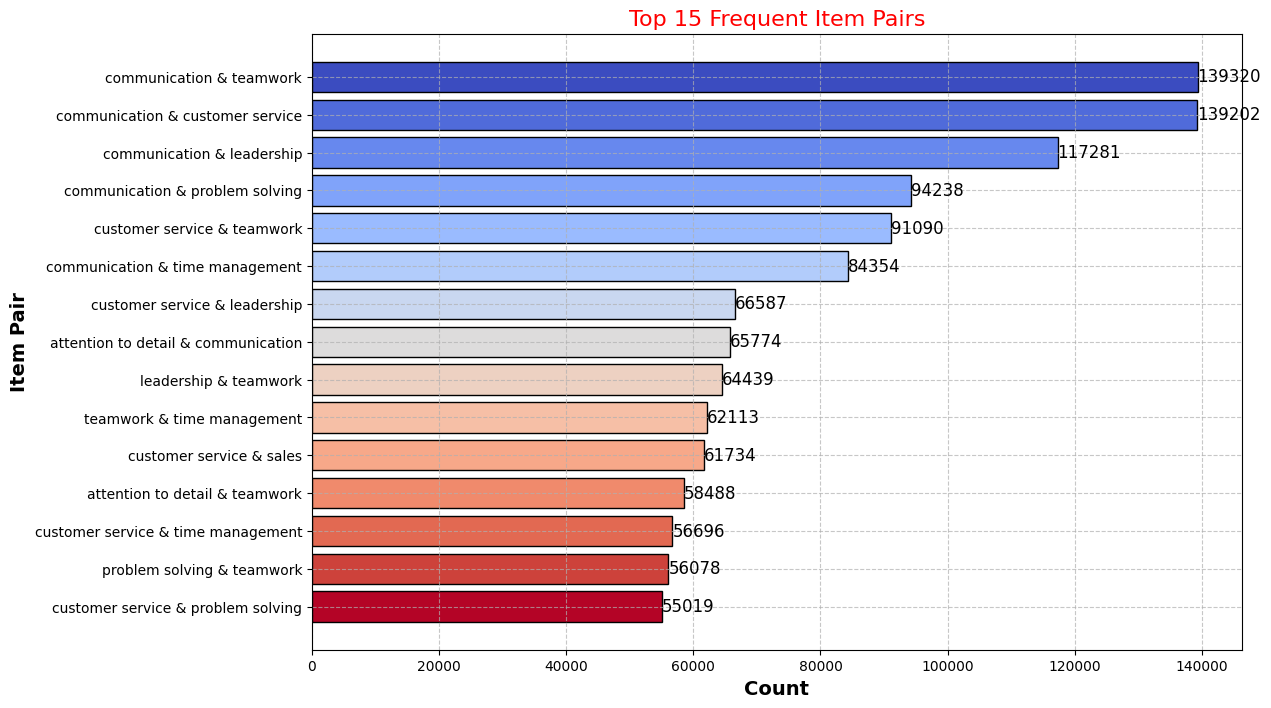

In [ ]:
# Convert to DataFrame for plot the pairs
pairs_df = second_pass.toDF(["pair", "count"]).toPandas()
pairs_df["pair"] = pairs_df["pair"].apply(lambda x: f"{x[0]} & {x[1]}")

# Plot top 15 frequent pairs
top_pairs = pairs_df.nlargest(15, "count")
plt.figure(figsize=(12, 8))
colors1 = plt.cm.coolwarm(np.linspace(0, 1, len(top_pairs)))
bars = plt.barh(top_pairs["pair"], top_pairs["count"], color=colors1, edgecolor='black')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Item Pair', fontsize=14, fontweight='bold')
plt.title('Top 15 Frequent Item Pairs', fontsize=16, color='red')
plt.gca().invert_yaxis()
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

Plot the most frequent triplets

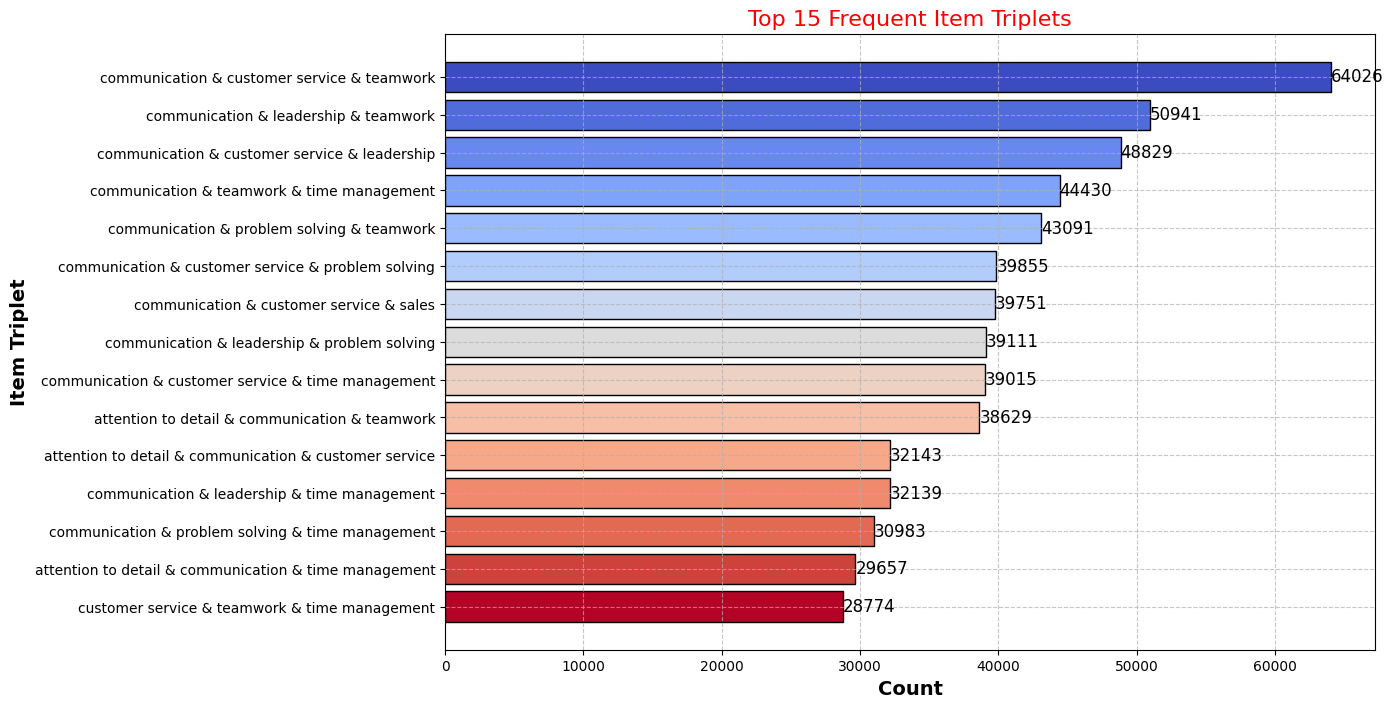

In [ ]:
# Convert to DataFrame for plot the triplets
triplet_df = third_pass.toDF(["triplet", "count"]).toPandas()
triplet_df["triplet"] = triplet_df["triplet"].apply(lambda x: f"{x[0]} & {x[1]} & {x[2]}")

# Plot top 15 frequent triplets
top_triplets = triplet_df.nlargest(15, "count")
plt.figure(figsize=(12, 8))
bars = plt.barh(top_triplets["triplet"], top_triplets["count"], color=colors1, edgecolor='black')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Item Triplet', fontsize=14, fontweight='bold')
plt.title('Top 15 Frequent Item Triplets', fontsize=16, color='red')
plt.gca().invert_yaxis()
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.show()


**FP-GROWTH ALGORITHM**

In [ ]:
# Create the FPGrowth object
fpGrowth = FPGrowth(itemsCol="skills", minSupport=0.02, minConfidence=0.6)

In [ ]:
# Fit the model to the baskets dataset
model = fpGrowth.fit(baskets)

In [ ]:
# Show the frequent patterns
frequentItemsets = model.freqItemsets
frequentItemsets.show(truncate=False)

+-------------------------------------------+------+
|items                                      |freq  |
+-------------------------------------------+------+
|[critical thinking]                        |52750 |
|[critical thinking, communication]         |31660 |
|[registered nurse]                         |33277 |
|[communication]                            |366270|
|[team leadership]                          |32994 |
|[customer service]                         |276786|
|[customer service, communication]          |139202|
|[documentation]                            |51531 |
|[teamwork]                                 |226212|
|[teamwork, customer service]               |91090 |
|[teamwork, customer service, communication]|64026 |
|[teamwork, communication]                  |139320|
|[organization]                             |46883 |
|[organization, communication]              |30709 |
|[401k]                                     |32580 |
|[safety]                                   |4

In [ ]:
# Show the association rules
associationRules = model.associationRules
associationRules.show(truncate=False)

+---------------------------------------+-----------------------+------------------+------------------+--------------------+
|antecedent                             |consequent             |confidence        |lift              |support             |
+---------------------------------------+-----------------------+------------------+------------------+--------------------+
|[problem solving]                      |[communication]        |0.6447591680350301|2.278520491805667 |0.07280635678498723 |
|[critical thinking]                    |[communication]        |0.6001895734597157|2.1210155820874896|0.024459870283884376|
|[cash handling]                        |[customer service]     |0.8862997695052256|4.144701687063765 |0.02168630950311543 |
|[teamwork, customer service]           |[communication]        |0.702887254363816 |2.483939883131626 |0.04946518176866649 |
|[attention to detail, customer service]|[communication]        |0.6445487176402174|2.2777767791748706|0.024833026232940477|


In [ ]:
# Predict additional skills for each basket
predictions = model.transform(baskets)
predictions.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+
|job_link                                                                                                                    |skills                                                                                                                                         